# Title: 

In [1]:
# packages

import datetime as dt
from loguru import logger
import numpy as np
import pandas as pd
from tqdm import tqdm

from quantified_strategies import strategy_utils

import constants
import model
import utils

2024-03-02 12:59:55.673 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU
2024-03-02 12:59:56.750 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


In [2]:
import torch
from quantified_strategies import loss

def my_cagr_loss(weights: torch.Tensor, returns: torch.Tensor, **kwargs) -> torch.Tensor:


    port_return = weights * returns
    try:
        port_return = torch.sum(port_return, dim=1)
    except IndexError:
        pass

    long_overnight_costs = loss.calc_long_overnight_cost(weights=weights, long_costs=kwargs.get("long_costs"), n_days=kwargs.get("n_days"))
    short_overnight_costs = loss.calc_short_overnight_cost(weights=weights, short_costs=kwargs.get("short_costs"), n_days=kwargs.get("n_days"))
    overnight_costs = long_overnight_costs + short_overnight_costs
        
    port_return = port_return - overnight_costs

    active_weights = 1 - weights[:, -1]
    active_port_return = port_return[torch.abs(active_weights) > 1e-5]
    mu_return = torch.mean(active_port_return)

    std_return = torch.std(active_port_return) if active_port_return.shape[0] > 3 else 0.01
    
    sharpe = mu_return / (std_return + 1e-8)
    multiplier = 252.0 * torch.sum(active_weights) / (len(active_weights) + 1e-8)
    ann_sharpe = sharpe * torch.sqrt(multiplier)

    return ann_sharpe


In [3]:
# parameters

# Trading Parameters
ASSETS = ["VUSA.L", "CNX1.L", utils.CASH]
START = dt.date(2012, 1, 1)
END = dt.date.today()

# Training Parameters
MIN_TRAINING_YEARS = 6

# Algorithm Parameters
LOSS_FUNCTION = my_cagr_loss
MAXIMIZE_LOSS = True
BATCH_SIZE = 64
EPOCHS = 2_000
LEARNING_RATE = 0.0001

# Allocation Parameters
ALLOW_NEGATIVE_WEIGHTS = False
MAX_LEVERAGE_WEIGHT = 1.5
MIN_LEVERAGE_WEIGHT = (MAX_LEVERAGE_WEIGHT - 1) / (len(ASSETS) - 1)
MAX_WEIGHT = MAX_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 1.0
MIN_WEIGHT = MIN_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 0.0

# Other Parameters
STORE = False

# Fetch costs involved in trading assets
LONG_OVERNIGHT_COSTS = [constants.LONG_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]
SHORT_OVERNIGHT_COSTS = [constants.SHORT_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]

In [4]:
def run(N: int = np.inf):

    def train_model(X_train_: pd.DataFrame, y_train_: pd.DataFrame, name: str = None, **other_train_):
        
        OUTPUT_SHAPE = y_train_.shape[1]
        INPUT_SHAPE = X_train_.shape[1]

        my_net = model.Net(
            input_shape=INPUT_SHAPE, 
            output_shape=OUTPUT_SHAPE, 
            layer_sizes=[8, 16, 8], 
            allow_negative_weights=ALLOW_NEGATIVE_WEIGHTS, 
            max_weight=MAX_WEIGHT, 
            min_weight=MIN_WEIGHT,
        ).to(device=model.DEVICE)

        model.train(
            net=my_net, 
            name=name,
            X=X_train_, 
            y=y_train_, 
            loss_fn=LOSS_FUNCTION, 
            lr=LEARNING_RATE, 
            batch_size=BATCH_SIZE, 
            epochs=EPOCHS, 
            maximize_loss=MAXIMIZE_LOSS, 
            store=STORE,
            long_costs=LONG_OVERNIGHT_COSTS, 
            short_costs=SHORT_OVERNIGHT_COSTS, 
            # test_size=0.3,
            test_size=0.0,
            patience=20,
            min_delta=0.005,
            **other_train_,
        )

        return my_net
        
    
    # Get data
    X_grouped, y_grouped, other = utils.get_data(assets=ASSETS, start=START, end=END)
    X_raw, y_raw = utils.get_raw_data(assets=ASSETS, is_classification=False, start=START, end=END)

    if X_grouped.index[0].date() > START:
        new_start = X_grouped.index[0].date()
    
    START_TRADING = dt.date(new_start.year + MIN_TRAINING_YEARS, 1, 1)
    
    # Fetch days to retrain model: quarterly
    retrain_dates = pd.date_range(start=START_TRADING, end=END, freq="6MS")

    all_strat_dicts_ = dict()
    i = 0
    for train_date, next_train_date in tqdm(zip(retrain_dates[:-1], retrain_dates[1:])):

        try:
            train_date = train_date.date()
            next_train_date = next_train_date.date()
    
            # Fetch training data: grouped data based on change in signals
            X_train, y_train = X_grouped.loc[X_grouped.index.date < train_date], y_grouped.loc[y_grouped.index.date < train_date]
            other_train = {key: value.loc[value.index.date < train_date] for key, value in other.items()}
    
            # Fetch testing data: raw data as would receive day-to-day
            if N == 0:
                X_test = X_raw.loc[X_raw.index.date >= train_date]
                y_test = y_raw.loc[y_raw.index.date >= train_date]
            else:
                X_test = X_raw.loc[(X_raw.index.date >= train_date) & (X_raw.index.date < next_train_date)]
                y_test = y_raw.loc[(y_raw.index.date >= train_date) & (y_raw.index.date < next_train_date)]
    
            my_net = train_model(X_train_=X_train, y_train_=y_train, name=f"{train_date:%Y%m%d}", **other_train)
            
            # Apply Model on test data
            strat_dict = utils.run(net=my_net, X_df=X_test, y_df=y_test, lost_costs=LONG_OVERNIGHT_COSTS, short_costs=SHORT_OVERNIGHT_COSTS)
    
            # Store 'strat_dict'
            all_strat_dicts_[train_date] = strat_dict
    
            for name, df in strat_dict.items():
                logger.info(f"{name = !r}: {strategy_utils.get_cumulative_return(returns=df['ret'], total=True):.3%}")
            print()
            
            if i >= N:
                break
            i += 1

        except KeyboardInterrupt:
            logger.warning("Received KeyboardInterrupt")
            break

    
    return all_strat_dicts_
    

In [5]:
all_strat_dicts = run()

C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\pytorch_nn_asset_allocator\utils.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()
C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\pytorch_nn_asset_allocator\utils.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()
0it [00:00, ?it/s]2024-03-02 13:00:01.835 | INFO     | model:train:93 - Training: '20180101'
2024-03-02 13:00:02.022 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4581, Val

2024-03-02 13:02:15.037 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.7156, Val Loss: 1.7156,Hit Rate: 58.66%, Val Hit Rate: 58.66%
2024-03-02 13:02:27.340 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.8610, Val Loss: 1.8610,Hit Rate: 58.52%, Val Hit Rate: 58.52%
2024-03-02 13:02:40.035 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.1157, Val Loss: 2.1157,Hit Rate: 58.66%, Val Hit Rate: 58.66%
2024-03-02 13:02:57.500 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.5157, Val Loss: 2.5157,Hit Rate: 59.66%, Val Hit Rate: 59.66%
2024-03-02 13:03:15.682 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.8415, Val Loss: 2.8415,Hit Rate: 60.80%, Val Hit Rate: 60.80%
2024-03-02 13:03:34.265 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.9848, Val Loss: 2.9848,Hit Rate: 60.65%, Val Hit Rate: 60.65%
2024-03-02 13:03:49.938 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 3.0546, Val Loss: 3.0546,Hit Rate: 60.51%, Val Hit Rate: 60

2024-03-02 13:06:12.779 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.3782, Val Loss: 1.3782,Hit Rate: 57.64%, Val Hit Rate: 57.64%
2024-03-02 13:06:21.262 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.5353, Val Loss: 1.5353,Hit Rate: 57.77%, Val Hit Rate: 57.77%
2024-03-02 13:06:29.455 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.6564, Val Loss: 1.6564,Hit Rate: 57.77%, Val Hit Rate: 57.77%
2024-03-02 13:06:37.461 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.7478, Val Loss: 1.7478,Hit Rate: 58.16%, Val Hit Rate: 58.16%
2024-03-02 13:06:45.716 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 1.9453, Val Loss: 1.9453,Hit Rate: 58.16%, Val Hit Rate: 58.16%
2024-03-02 13:06:53.943 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.2706, Val Loss: 2.2706,Hit Rate: 59.72%, Val Hit Rate: 59.72%
2024-03-02 13:07:02.035 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.4709, Val Loss: 2.4709,Hit Rate: 60.23%, Val Hit Rate: 60

2024-03-02 13:09:22.078 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.5139, Val Loss: 1.5139,Hit Rate: 57.06%, Val Hit Rate: 57.06%
2024-03-02 13:09:34.526 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.7126, Val Loss: 1.7126,Hit Rate: 57.90%, Val Hit Rate: 57.90%
2024-03-02 13:09:46.888 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.1136, Val Loss: 2.1136,Hit Rate: 58.99%, Val Hit Rate: 58.99%
2024-03-02 13:09:58.527 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.5652, Val Loss: 2.5652,Hit Rate: 60.68%, Val Hit Rate: 60.68%
2024-03-02 13:10:10.217 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.7488, Val Loss: 2.7488,Hit Rate: 61.28%, Val Hit Rate: 61.28%
2024-03-02 13:10:21.812 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.8187, Val Loss: 2.8187,Hit Rate: 61.04%, Val Hit Rate: 61.04%
2024-03-02 13:10:33.578 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.8618, Val Loss: 2.8618,Hit Rate: 60.92%, Val Hit Rate: 60

2024-03-02 13:11:36.152 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4880, Val Loss: 1.4880,Hit Rate: 58.06%, Val Hit Rate: 58.06%
2024-03-02 13:11:47.151 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.6965, Val Loss: 1.6965,Hit Rate: 57.95%, Val Hit Rate: 57.95%
2024-03-02 13:11:57.894 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.8501, Val Loss: 1.8501,Hit Rate: 57.51%, Val Hit Rate: 57.51%
2024-03-02 13:12:08.471 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 1.9741, Val Loss: 1.9741,Hit Rate: 58.18%, Val Hit Rate: 58.18%
2024-03-02 13:12:18.723 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.2484, Val Loss: 2.2484,Hit Rate: 59.96%, Val Hit Rate: 59.96%
2024-03-02 13:12:29.011 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.4678, Val Loss: 2.4678,Hit Rate: 60.51%, Val Hit Rate: 60.51%
2024-03-02 13:12:38.942 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.5862, Val Loss: 2.5862,Hit Rate: 60.96%, Val Hit Rate: 60

2024-03-02 13:13:34.619 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4921, Val Loss: 1.4921,Hit Rate: 57.69%, Val Hit Rate: 57.69%
2024-03-02 13:13:45.732 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.6328, Val Loss: 1.6328,Hit Rate: 57.79%, Val Hit Rate: 57.79%
2024-03-02 13:13:56.879 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9485, Val Loss: 1.9485,Hit Rate: 58.43%, Val Hit Rate: 58.43%
2024-03-02 13:14:07.543 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.3604, Val Loss: 2.3604,Hit Rate: 60.02%, Val Hit Rate: 60.02%
2024-03-02 13:14:17.989 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.5099, Val Loss: 2.5099,Hit Rate: 61.19%, Val Hit Rate: 61.19%
2024-03-02 13:14:28.325 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.5761, Val Loss: 2.5761,Hit Rate: 61.19%, Val Hit Rate: 61.19%
2024-03-02 13:14:38.304 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.6208, Val Loss: 2.6208,Hit Rate: 61.08%, Val Hit Rate: 61

2024-03-02 13:16:51.258 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.5190, Val Loss: 1.5190,Hit Rate: 58.13%, Val Hit Rate: 58.13%
2024-03-02 13:17:02.143 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.6912, Val Loss: 1.6912,Hit Rate: 58.43%, Val Hit Rate: 58.43%
2024-03-02 13:17:13.331 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.1213, Val Loss: 2.1213,Hit Rate: 59.94%, Val Hit Rate: 59.94%
2024-03-02 13:17:24.640 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.4632, Val Loss: 2.4632,Hit Rate: 61.14%, Val Hit Rate: 61.14%
2024-03-02 13:17:35.621 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.5710, Val Loss: 2.5710,Hit Rate: 61.14%, Val Hit Rate: 61.14%
2024-03-02 13:17:46.452 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.6235, Val Loss: 2.6235,Hit Rate: 61.65%, Val Hit Rate: 61.65%
2024-03-02 13:17:57.241 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.6584, Val Loss: 2.6584,Hit Rate: 61.75%, Val Hit Rate: 61

2024-03-02 13:18:40.507 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4865, Val Loss: 1.4865,Hit Rate: 58.67%, Val Hit Rate: 58.67%
2024-03-02 13:18:52.037 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.7397, Val Loss: 1.7397,Hit Rate: 58.19%, Val Hit Rate: 58.19%
2024-03-02 13:19:03.488 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.9192, Val Loss: 1.9192,Hit Rate: 58.38%, Val Hit Rate: 58.38%
2024-03-02 13:19:15.090 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.2388, Val Loss: 2.2388,Hit Rate: 60.19%, Val Hit Rate: 60.19%
2024-03-02 13:19:27.006 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.5886, Val Loss: 2.5886,Hit Rate: 61.52%, Val Hit Rate: 61.52%
2024-03-02 13:19:38.856 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.7076, Val Loss: 2.7076,Hit Rate: 61.43%, Val Hit Rate: 61.43%
2024-03-02 13:19:50.522 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.7559, Val Loss: 2.7559,Hit Rate: 61.52%, Val Hit Rate: 61

2024-03-02 13:20:24.975 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.4275, Val Loss: 1.4275,Hit Rate: 58.15%, Val Hit Rate: 58.15%
2024-03-02 13:20:37.063 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.7504, Val Loss: 1.7504,Hit Rate: 59.14%, Val Hit Rate: 59.14%
2024-03-02 13:20:49.244 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 2.2137, Val Loss: 2.2137,Hit Rate: 59.59%, Val Hit Rate: 59.59%
2024-03-02 13:21:01.722 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.6012, Val Loss: 2.6012,Hit Rate: 61.75%, Val Hit Rate: 61.75%
2024-03-02 13:21:14.189 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.7361, Val Loss: 2.7361,Hit Rate: 61.48%, Val Hit Rate: 61.48%
2024-03-02 13:21:26.413 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.7910, Val Loss: 2.7910,Hit Rate: 61.75%, Val Hit Rate: 61.75%
2024-03-02 13:21:38.697 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.8198, Val Loss: 2.8198,Hit Rate: 61.66%, Val Hit Rate: 61

2024-03-02 13:22:11.924 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.2242, Val Loss: 1.2242,Hit Rate: 57.82%, Val Hit Rate: 57.82%
2024-03-02 13:22:25.201 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.4184, Val Loss: 1.4184,Hit Rate: 57.74%, Val Hit Rate: 57.74%
2024-03-02 13:22:38.167 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.8572, Val Loss: 1.8572,Hit Rate: 59.10%, Val Hit Rate: 59.10%
2024-03-02 13:22:51.244 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.3630, Val Loss: 2.3630,Hit Rate: 60.54%, Val Hit Rate: 60.54%
2024-03-02 13:23:04.145 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.4897, Val Loss: 2.4897,Hit Rate: 61.73%, Val Hit Rate: 61.73%
2024-03-02 13:23:17.694 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.5391, Val Loss: 2.5391,Hit Rate: 61.56%, Val Hit Rate: 61.56%
2024-03-02 13:23:31.550 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.5717, Val Loss: 2.5717,Hit Rate: 61.65%, Val Hit Rate: 61

2024-03-02 13:26:39.869 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.1830, Val Loss: 1.1830,Hit Rate: 57.21%, Val Hit Rate: 57.21%
2024-03-02 13:26:50.479 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.3742, Val Loss: 1.3742,Hit Rate: 57.37%, Val Hit Rate: 57.37%
2024-03-02 13:27:00.662 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.5223, Val Loss: 1.5223,Hit Rate: 57.53%, Val Hit Rate: 57.53%
2024-03-02 13:27:10.757 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.0045, Val Loss: 2.0045,Hit Rate: 59.62%, Val Hit Rate: 59.62%
2024-03-02 13:27:20.713 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.3655, Val Loss: 2.3655,Hit Rate: 60.82%, Val Hit Rate: 60.82%
2024-03-02 13:27:30.776 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.4802, Val Loss: 2.4802,Hit Rate: 60.82%, Val Hit Rate: 60.82%
2024-03-02 13:27:40.787 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.5246, Val Loss: 2.5246,Hit Rate: 60.74%, Val Hit Rate: 60

2024-03-02 13:28:10.704 | INFO     | model:train:130 - Epoch: 0 / 2000, Loss: 1.3372, Val Loss: 1.3372,Hit Rate: 57.54%, Val Hit Rate: 57.54%
2024-03-02 13:28:21.104 | INFO     | model:train:130 - Epoch: 50 / 2000, Loss: 1.5353, Val Loss: 1.5353,Hit Rate: 57.77%, Val Hit Rate: 57.77%
2024-03-02 13:28:31.710 | INFO     | model:train:130 - Epoch: 100 / 2000, Loss: 1.8527, Val Loss: 1.8527,Hit Rate: 58.61%, Val Hit Rate: 58.61%
2024-03-02 13:28:42.220 | INFO     | model:train:130 - Epoch: 150 / 2000, Loss: 2.3323, Val Loss: 2.3323,Hit Rate: 60.52%, Val Hit Rate: 60.52%
2024-03-02 13:28:53.069 | INFO     | model:train:130 - Epoch: 200 / 2000, Loss: 2.4399, Val Loss: 2.4399,Hit Rate: 60.44%, Val Hit Rate: 60.44%
2024-03-02 13:29:03.433 | INFO     | model:train:130 - Epoch: 250 / 2000, Loss: 2.4872, Val Loss: 2.4872,Hit Rate: 60.67%, Val Hit Rate: 60.67%
2024-03-02 13:29:13.773 | INFO     | model:train:130 - Epoch: 300 / 2000, Loss: 2.5218, Val Loss: 2.5218,Hit Rate: 60.75%, Val Hit Rate: 60

In [6]:
# TODO: Fix update dataset to be progressive/sequential

In [7]:
strat_df = pd.concat([strat_dict["strat"] for date, strat_dict in all_strat_dicts.items()], axis=0)
benchmark_df = pd.concat([strat_dict["benchmark"] for date, strat_dict in all_strat_dicts.items()], axis=0)
hodl_df = pd.concat([strat_dict["hodl"] for date, strat_dict in all_strat_dicts.items()], axis=0)

In [8]:
FROM_DATE = dt.date(2010, 1, 1)
TO_DATE = dt.date(2023, 12, 31)

In [9]:
hodl_df_ = hodl_df.loc[(hodl_df.index.date >= FROM_DATE) & (hodl_df.index.date <= TO_DATE)]
benchmark_df_ = benchmark_df.loc[(benchmark_df.index.date >= FROM_DATE) & (benchmark_df.index.date <= TO_DATE)]
strat_df_ = strat_df.loc[(strat_df.index.date >= FROM_DATE) & (strat_df.index.date <= TO_DATE)]

In [10]:
hodl_ret = strategy_utils.get_cumulative_return(returns=hodl_df_["ret"], total=False)
benchmark_ret = strategy_utils.get_cumulative_return(returns=benchmark_df_["ret"], total=False)
strat_ret = strategy_utils.get_cumulative_return(returns=strat_df_["ret"], total=False)

hodl_pos = hodl_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
benchmark_pos = benchmark_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
strat_pos = strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)

In [11]:
import matplotlib.pyplot as plt

<Axes: >

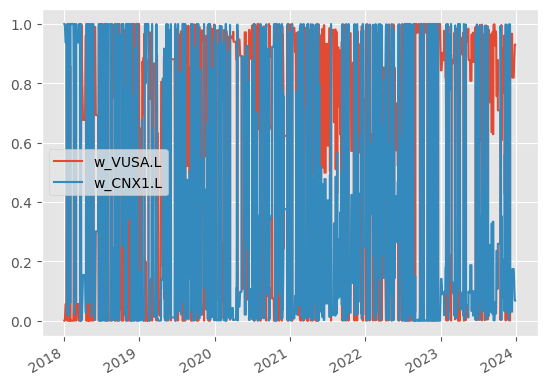

In [12]:
strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].plot()

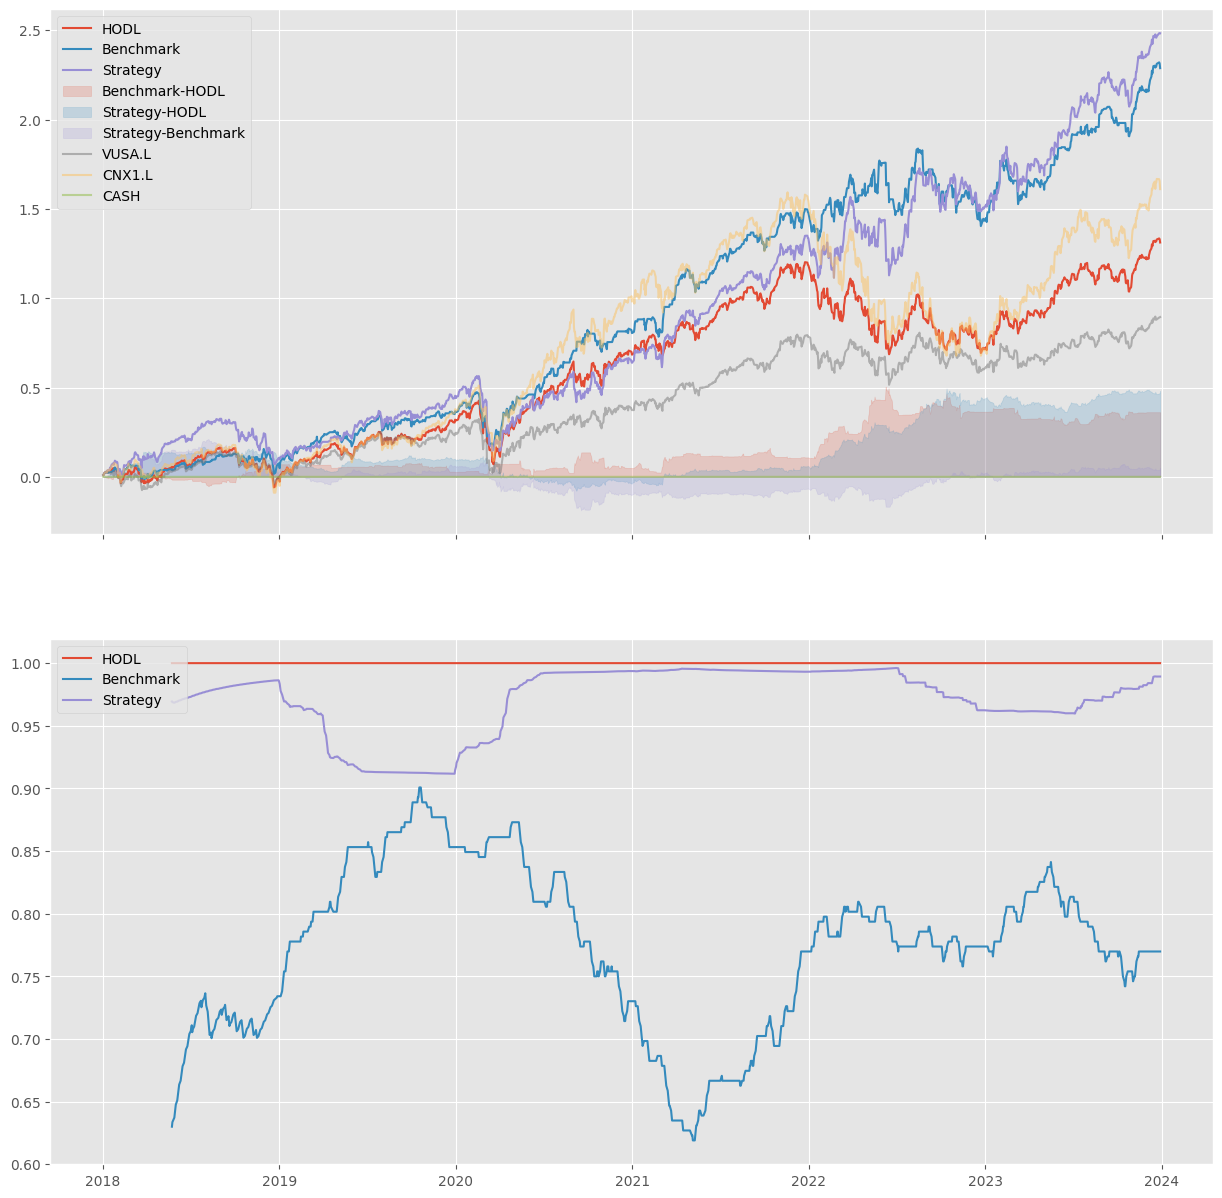

In [13]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(15, 15), sharex="col", nrows=2)

ax[0].plot(hodl_ret, label="HODL", color=colors[0])
ax[0].plot(benchmark_ret, label="Benchmark", color=colors[1])
ax[0].plot(strat_ret, label="Strategy", color=colors[2])

ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=benchmark_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[0],
    alpha=0.2,
    label="Benchmark-HODL",
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[1],
    alpha=0.2,
    label="Strategy-HODL",
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-benchmark_df_["ret"], total=False), 
    color=colors[2],
    alpha=0.2,    
    label="Strategy-Benchmark",
)
for i, asset in enumerate(ASSETS):
    ax[0].plot(strategy_utils.get_cumulative_return(returns=hodl_df_[asset], total=False), label=asset, color=colors[3+i], alpha=0.5)
ax[0].legend(loc="upper left")

# Activity
ax[1].plot(hodl_pos.rolling(window=252, min_periods=100).mean(), label="HODL", color=colors[0])
ax[1].plot(benchmark_pos.rolling(window=252, min_periods=100).mean(), label="Benchmark", color=colors[1])
ax[1].plot(strat_pos.rolling(window=252, min_periods=100).mean(), label="Strategy", color=colors[2])
ax[1].legend(loc="upper left")

plt.show()


In [14]:
desc = pd.concat([
    strategy_utils.describe(returns=strat_df_["ret"], pos=strat_pos, daily=True).to_frame(name="strategy"),
    strategy_utils.describe(returns=benchmark_df_["ret"], pos=benchmark_pos, daily=True).to_frame(name="benchmark"),
    strategy_utils.describe(returns=hodl_df_["ret"], pos=hodl_pos, daily=True).to_frame(name="hodl")
], axis=1)
desc

,strategy,benchmark,hodl
Asset,Undefined,Undefined,Undefined
Start,2018-01-02,2018-01-02,2018-01-02
End,2023-12-29,2023-12-29,2023-12-29
Mean Return,0.08959%,0.10857%,0.06156%
Total Return,248.28%,228.77%,131.17%
Median Return,0.12217%,0.14607%,0.11146%
1st Quartile,-0.42803%,-0.44734%,-0.49263%
3rd Quartile,0.68868%,0.68630%,0.63285%
Std Dev Return,1.17370%,1.12692%,1.09904%
CAGR,8.267 bps,10.221 bps,5.551 bps


<Axes: >

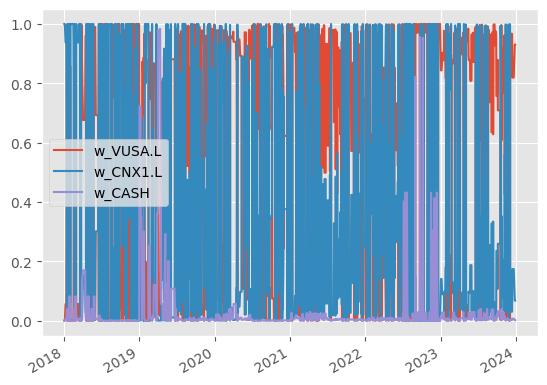

In [15]:
strat_df_[[f"w_{asset}" for asset in ASSETS]].plot()

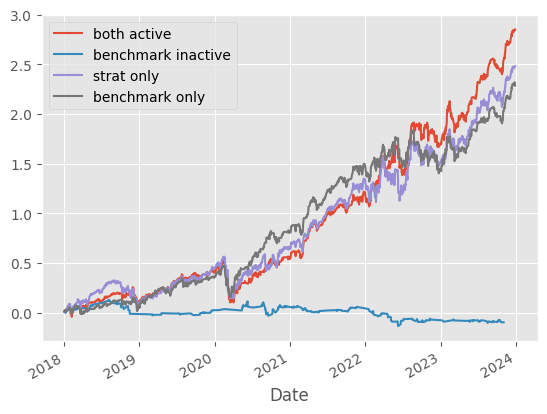

In [17]:
strategy_utils.get_cumulative_return(returns=strat_df_.loc[benchmark_df_[f"w_{utils.CASH}"] == 0.0, "ret"], total=False).plot(label="both active")
strategy_utils.get_cumulative_return(returns=strat_df_.loc[benchmark_df_[f"w_{utils.CASH}"] == 1.0, "ret"], total=False).plot(label="benchmark inactive")
strategy_utils.get_cumulative_return(returns=strat_df_.loc[:, "ret"], total=False).plot(label="strat only")
strategy_utils.get_cumulative_return(returns=benchmark_df_.loc[:, "ret"], total=False).plot(label="benchmark only")
plt.legend(loc="upper left")
plt.show()
